# **Data Preprocessing**
---

This is the first piece of code within the series of SemEval 2017 Task 4 challenge.

In this notebook, we will read the raw datasets consisting of a series of text files. We will preprocess them and then join them all as a single training and testing dataset that can be used for later purpose.

In this notebook, we also perform an exploratory data analysis to give us a brief insight of what the dataset look like.


In [20]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries and Variables

* Reading `config.yaml` which contains all ML parameters as well as filepaths
* Import all dependencies and libraries







In [0]:
# load configuration file that store all the constant and parameters settings
import yaml
CONFIG_YAML_FILEPATH = '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/src/config.yaml'
with open(CONFIG_YAML_FILEPATH, 'r') as file:
  cfg = yaml.safe_load(file)

In [22]:
# install additional dependencies
! pip install -r {cfg['paths']['requirements']}

import pandas as pd
import os
import torch
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import csv
import numpy as np

# Load Dataset and Data Preprocessing

## Preprocess Additional Dataset
In task A, there are some additional datasets (sms and livejournal datasets) that were given from the competition apart from the standard twitter corpus. We can use both of these additional datasets, after we preprocess the formatting so that it matches the rest of the twitter datasets.

In [23]:
task_a_train_additional_dfs = {}

for filename in cfg['paths']['train_additional_dataset_filenames']:
  # read additional corpora
  task_a_train_additional_dfs[filename] = pd.read_csv(os.path.join(cfg['paths']['train_folder_task_a'], filename), sep='\t', header=None, quoting=csv.QUOTE_NONE)
  
  if filename == 'livejournal-2014test-A.tsv':
    # remove the 0-th column from livejournal corpora, as it is unnecessary
    task_a_train_additional_dfs[filename] = task_a_train_additional_dfs[filename].drop(columns=[0])
  elif filename == 'sms-2013test-A.tsv':
    # remove the 1st column from sms corpora, as it is unnecessary
    task_a_train_additional_dfs[filename] = task_a_train_additional_dfs[filename].drop(columns=[1])
  
  # reset the column index to make it incremental
  task_a_train_additional_dfs[filename].columns = range(task_a_train_additional_dfs[filename].shape[1])
  
  print(task_a_train_additional_dfs[filename])

             0         1                                                  2
0     LJ111111  negative  I know I missed something here , but what does...
1     LJ111113   neutral  What do you think of Beside Ourselves as a tit...
2     LJ111114  positive                    :D I intend to be one someday .
3     LJ111117  negative  LLLINKKK LLLINKKK IIIMAGEEELLLINKKK The choice...
4     LJ111119   neutral                     LLLINKKK Some more mountains .
...        ...       ...                                                ...
1137  LJ113616  positive                     Maybe it was - his - fantasy ?
1138  LJ113618  negative  It was ok , but they always just seem so nervo...
1139  LJ113621  positive  It is streamable from YepRoc -- matter of fact...
1140  LJ113623  positive  comment telling me who you are , or how you fo...
1141  LJ113625   neutral  im on myspace ... ill try and find you and add...

[1142 rows x 3 columns]
          0         1                                          

## Make Datasets As Pandas' DataFrames and Cleaning Dataset



In [0]:
def append_txt_files_as_one_dataframe(folderpath, filename_keywords_list, additional_dataset_dfs=None):
  dataset_per_file_dfs = {}
  dataset_df = pd.DataFrame()
  filenames = os.listdir(folderpath)
  
  # open txt files (in tsv formatting)
  for filename in filenames:
    # if the filename contains a keyword in the filename_keywords_list, then open the txt file
    # this is to avoid opening unnecessary txt such as readme.txt file.
    if any(keyword in filename for keyword in filename_keywords_list):
      dataset_per_file_dfs[filename] = pd.read_csv(os.path.join(folderpath, filename), sep="\t", header=None, quoting=csv.QUOTE_NONE)
      print('shape : ', dataset_per_file_dfs[filename].shape, '\tfilename: ', filename)

  # combine the original dataset with additional dataset (if any)
  if additional_dataset_dfs is not None:
    for key, value in additional_dataset_dfs.items():
      dataset_per_file_dfs[key] = value

  # append all the files as one dataframe
  for key, value in dataset_per_file_dfs.items():
    # print(key, '\t', i, '\t', dataset_per_file_df[key].shape[0])
    dataset_df = dataset_df.append(dataset_per_file_dfs[key], ignore_index=True)
  return dataset_df

In [0]:
def clean_dataframe_format(df, new_column_name_list, drop_column_list=[]):
  # drop unnecessary column
  df = df.drop(columns=drop_column_list)
  
  # rename column
  df.columns = new_column_name_list

  # remove row in dataframe if the 'text' or 'sentiment' column value is missing
  df = df.dropna(subset=['sentiment', 'text'], how='any').reset_index(drop=True)
  
  # remove row if the sentiment is not 'positive', 'negative' or 'neutral'
  # this happens in the dataset, for example, there are some rows
  # where its sentiments are 'off topic'
  valid_sentiments = ['positive', 'negative', 'neutral']
  df = df[df['sentiment'].isin(valid_sentiments)].reset_index(drop=True)
  return df

In [26]:
# read dataset files and append it as one pandas dataframe
if cfg['task_a']['use_additional_dataset']:
  task_a_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_a'], ['twitter'], task_a_train_additional_dfs)
else:
  task_a_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_a'], ['twitter'])

task_a_train_df = clean_dataframe_format(task_a_train_df, ['id', 'sentiment', 'text'], drop_column_list=[3])

shape :  (2000, 3) 	filename:  twitter-2016devtest-A.txt
shape :  (1999, 3) 	filename:  twitter-2016dev-A.txt
shape :  (6000, 3) 	filename:  twitter-2016train-A.txt
shape :  (1654, 3) 	filename:  twitter-2013dev-A.txt
shape :  (3547, 3) 	filename:  twitter-2013test-A.txt
shape :  (9684, 3) 	filename:  twitter-2013train-A.txt
shape :  (1853, 3) 	filename:  twitter-2014test-A.txt
shape :  (2390, 3) 	filename:  twitter-2015test-A.txt
shape :  (489, 3) 	filename:  twitter-2015train-A.txt
shape :  (86, 3) 	filename:  twitter-2014sarcasm-A.txt
shape :  (20633, 4) 	filename:  twitter-2016test-A.txt


In [27]:
task_b_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_b'], ['twitter'])
task_b_train_df = clean_dataframe_format(task_b_train_df, ['id', 'topic','sentiment', 'text'], drop_column_list=[4])
task_b_train_df.info()

shape :  (4346, 4) 	filename:  twitter-2016train-BD.txt
shape :  (1325, 4) 	filename:  twitter-2016dev-BD.txt
shape :  (1417, 4) 	filename:  twitter-2016devtest-BD.txt
shape :  (489, 4) 	filename:  twitter-2015train-BD.txt
shape :  (10552, 5) 	filename:  twitter-2016test-BD.txt
shape :  (2383, 5) 	filename:  twitter-2015testBD.txt
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20508 entries, 0 to 20507
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         20508 non-null  object
 1   topic      20508 non-null  object
 2   sentiment  20508 non-null  object
 3   text       20508 non-null  object
dtypes: object(4)
memory usage: 641.0+ KB


In [28]:
task_a_test_df = pd.read_csv(cfg['paths']['test_file_task_a'], sep='\t', header=None, quoting=csv.QUOTE_NONE)
task_a_test_df = clean_dataframe_format(task_a_test_df, ['id', 'sentiment', 'text'])
task_a_test_df

,id,sentiment,text
0,801989080477154944,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...
1,801989272341453952,positive,Ariana Grande KIIS FM Yours Truly CD listening...
2,801990978424962944,positive,Ariana Grande White House Easter Egg Roll in W...
3,801996232553963008,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
4,801998343442407040,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...
...,...,...,...
12279,805699615781625856,positive,@dansen17 update: Zac Efron kissing a puppy ht...
12280,805701709356003328,neutral,#zac efron sex pic skins michelle sex https://...
12281,805701818357579776,neutral,First Look at Neighbors 2 with Zac Efron Shirt...
12282,805703557081075712,neutral,zac efron poses nude #lovely libra porn https:...


In [29]:
task_b_test_df = pd.read_csv(cfg['paths']['test_file_task_b'], sep='\t', header=None, quoting=csv.QUOTE_NONE)
task_b_test_df = clean_dataframe_format(task_b_test_df, ['id', 'topic', 'sentiment', 'text'])
task_b_test_df

,id,topic,sentiment,text
0,801989272341453952,#ArianaGrande,positive,Ariana Grande KIIS FM Yours Truly CD listening...
1,801990978424962944,#ArianaGrande,positive,Ariana Grande White House Easter Egg Roll in W...
2,801996232553963008,#ArianaGrande,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
3,801998343442407040,#ArianaGrande,positive,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...
4,802001659970744064,#ArianaGrande,positive,Hairspray Live! Previews at the Macy's Thanksg...
...,...,...,...,...
6180,805696468959002624,zac efron,positive,"Abby *talking about the Hamilton soundtrack"": ..."
6181,805699412257181697,zac efron,positive,can we like get zac efron or justin bieber for...
6182,805699615781625856,zac efron,positive,@dansen17 update: Zac Efron kissing a puppy ht...
6183,805701818357579776,zac efron,positive,First Look at Neighbors 2 with Zac Efron Shirt...


In [0]:
# save the cleaned datasets as csv
def df_to_csv(df, filtered_cols=[], csv_filename='output.csv', index_label='row_num'):
  '''
    df           : the panda dataframe
    filtered_cols: if not empty, it will only include the listed column name
    csv_filename : the csv filename
    index_label  : column name for the dataframe's index in the csv
  '''
  # filtering columns
  if len(filtered_cols) > 0:
    df = df[filtered_cols]
    
  # save to csv
  df.to_csv(
      csv_filename,
      sep='\t',
      index_label=index_label
  )

df_to_csv(task_a_train_df, ['text', 'sentiment'], cfg['paths']['cleaned_train_a'])
df_to_csv(task_a_test_df, ['text', 'sentiment'], cfg['paths']['cleaned_test_a'])

# append the topic to the text for task B
task_b_train_df['ori_text'] = task_b_train_df['text']
task_b_train_df['text'] = task_b_train_df['text'].map(str) + " " + task_b_train_df['topic']

task_b_test_df['ori_text'] = task_b_test_df['text']
task_b_test_df['text'] = task_b_test_df['text'].map(str) + " " + task_b_train_df['topic']

# cut sentiments other than positive&negative (cut the neutral ones)
task_b_train_df = task_b_train_df[(task_b_train_df['sentiment'] == 'positive') | (task_b_train_df['sentiment'] == 'negative')]

df_to_csv(task_b_train_df, ['text', 'sentiment', 'topic', 'ori_text'], cfg['paths']['cleaned_train_b'])
df_to_csv(task_b_test_df, ['text', 'sentiment', 'topic'], cfg['paths']['cleaned_test_b'])

# Exploratory Data Analysis (EDA)

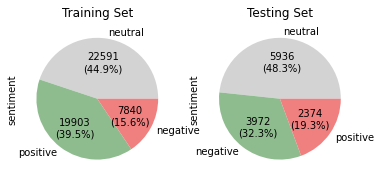

In [31]:
def show_autopct(pct, data):
  absolute = int(pct/100.*np.sum(data))
  return  "{:d}\n({:.1f}%)".format(absolute, pct)
  
plt.subplot(1, 2, 1)
task_a_train_df['sentiment'].value_counts().plot(
    kind='pie',
    autopct=lambda pct: show_autopct(pct, task_a_train_df['sentiment'].value_counts()),
    colors=['lightgray', 'darkseagreen', 'lightcoral']
);
plt.title('Training Set');


plt.subplot(1, 2, 2)
task_a_test_df['sentiment'].value_counts().plot(
    kind='pie',
    # figsize=(7,4),
    autopct=lambda pct: show_autopct(pct, task_a_test_df['sentiment'].value_counts()),
    colors=['lightgray', 'darkseagreen', 'lightcoral']
);
plt.title('Testing Set');




In [32]:
task_b_train_df[task_b_train_df['text'].str.contains('not')]

,id,topic,sentiment,text,ori_text
4,629226490152914944,@microsoft,positive,"Microsoft, I may not prefer your gaming branch...","Microsoft, I may not prefer your gaming branch..."
8,629797991826722816,@microsoft,negative,"After attempting a reinstall, it still bricks,...","After attempting a reinstall, it still bricks,..."
16,631543121407442946,@microsoft,negative,@Microsoft support for 365 has been terrible. ...,@Microsoft support for 365 has been terrible. ...
20,632536348419690496,@microsoft,negative,@eyesonfoxorg @Microsoft I'm still using Vista...,@eyesonfoxorg @Microsoft I'm still using Vista...
22,632810315227467776,@microsoft,negative,@MisterMetokur @Microsoft @ATT @NSAGov That's ...,@MisterMetokur @Microsoft @ATT @NSAGov That's ...
...,...,...,...,...,...
20377,521536294670065664,welbeck,positive,"""@asadaslamawan today was all about Ozil not b...","""@asadaslamawan today was all about Ozil not b..."
20433,522106648916393985,wwat,positive,"""GUYS there's a chance I might go back to the ...","""GUYS there's a chance I might go back to the ..."
20436,521315004289912832,wwat,positive,i may or may not be driving an hour and a half...,i may or may not be driving an hour and a half...
20474,520384978820296705,yougov,negative,"""@LouiseBaldock great work; you may or may not...","""@LouiseBaldock great work; you may or may not..."


In [33]:
positive = task_b_train_df[task_b_train_df['sentiment'] == 'positive']['topic'].value_counts(sort=False).to_frame(name='positive')
negative = task_b_train_df[task_b_train_df['sentiment'] == 'negative']['topic'].value_counts(sort=False).to_frame(name='negative')
neutral = task_b_train_df[task_b_train_df['sentiment'] == 'neutral']['topic'].value_counts(sort=False).to_frame(name='neutral')
joined = positive.join(negative).join(neutral)

joined = joined[(joined['positive'] > 0) & (joined['negative']>0)]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(joined)

                       positive  negative  neutral
dunkin                      156      18.0      NaN
taylor swift                 84       1.0      NaN
harper                       18      41.0      NaN
modi                          6       4.0      NaN
ac/dc                        89       2.0      NaN
murray                       90      24.0      NaN
justin                       69       9.0      NaN
amazon prime day             43      43.0      NaN
kurt cobain                  61       7.0      NaN
cate blanchett               41       2.0      NaN
ukip                         28      31.0      NaN
disney                       12       1.0      NaN
jurassic world               84       5.0      NaN
bulls                         9       1.0      NaN
nintendo                     54       8.0      NaN
david wright                 92       7.0      NaN
janet jackson                95       3.0      NaN
rick perry                   23      41.0      NaN
u2                           85

<BarContainer object of 303 artists>

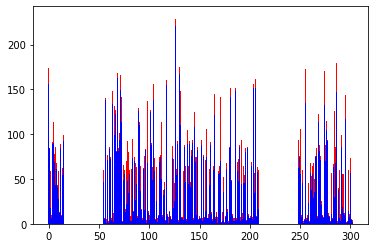

In [34]:
plt.bar(range(joined.shape[0]), joined['positive'], label='positive', color='blue')
plt.bar(range(joined.shape[0]), joined['negative'], label='negative', color='red', bottom=joined['positive'])